<a href="https://colab.research.google.com/github/zakaria-aabbou/Deep_Learning/blob/main/TP4/DeepLearning_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;font-size: 3em"> TP4 : Autoencoders & Convolutions Neural Networks </h1>

# Réalisé par : AABBOU ZAKARIA

## PART1: Autoencoders

1. Import libraries

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

2. Convert vector to image
The following function allows to convert a vector to a image


In [2]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

3. We now write a function wchi allows to display the images using the omshow() function.

In [3]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

4. Define a data loading step and load the MNIST dataset

In [4]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



5. Fix the used device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6. Define the Autoencoder model architecture and reconstruction loss
with : 
n = 28 x 28 = 784

A. Use d = 30  for standard AE (under-complete hidden layer)

B. Use d = 500 for denoising AE (over-complete hidden layer)




## A. Use d = 30 for standard AE (under-complete hidden layer)

In [6]:
d=30;

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(), # la fonction d'activation utilisée ici c'est la tangente hyperbolique (tanh) qui varie entre -1 et 1
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )
    # fonction qui permet d'encoder et décoder l'information
    def forward(self, x):
        x = self.encoder(x) # Encogage
        x = self.decoder(x) # Décodage 
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss() # la fonction de coût

7. Configure the optimiser. We use here : learning_rate equals to 1e-3

In [7]:


learning_rate = 1e-3 # soit 0.001,
# Appliquer l'algo du gradient pour minimiser le coût
optimizer = torch.optim.Adam(
    model.parameters(), # récupérer tous les paramètres de l'auto-encodeur
    lr=learning_rate,  # déterminer la vitesse à laquelle on ajuste les poids
)

8. Train the standard autoencoder and the denoising autoencoder using the following code :


epoch [1/20], loss:0.2054
epoch [2/20], loss:0.1589
epoch [3/20], loss:0.1242
epoch [4/20], loss:0.1078
epoch [5/20], loss:0.0946
epoch [6/20], loss:0.0860
epoch [7/20], loss:0.0861
epoch [8/20], loss:0.0848
epoch [9/20], loss:0.0797
epoch [10/20], loss:0.0725
epoch [11/20], loss:0.0748
epoch [12/20], loss:0.0695
epoch [13/20], loss:0.0655
epoch [14/20], loss:0.0645
epoch [15/20], loss:0.0641
epoch [16/20], loss:0.0584
epoch [17/20], loss:0.0581
epoch [18/20], loss:0.0565
epoch [19/20], loss:0.0569
epoch [20/20], loss:0.0571


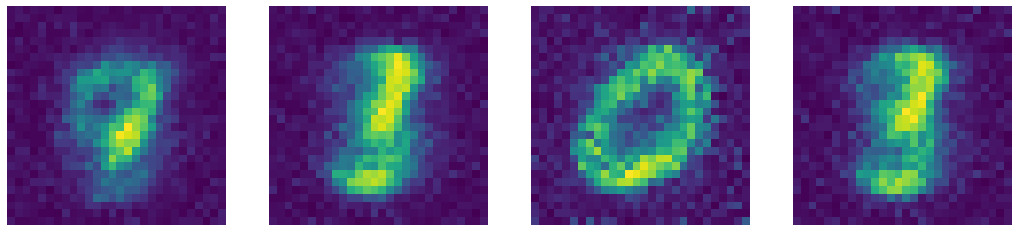

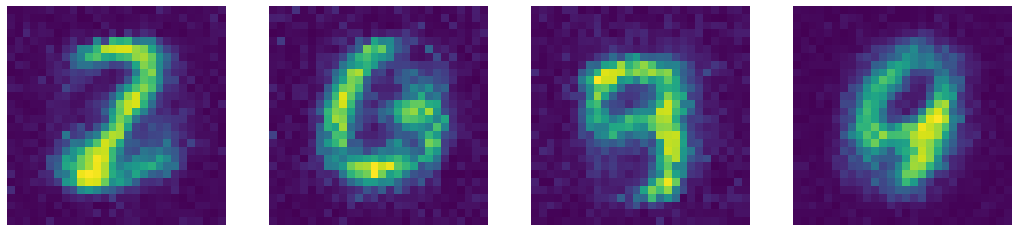

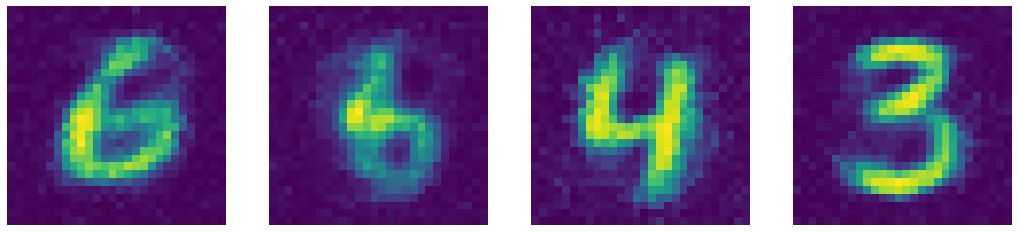

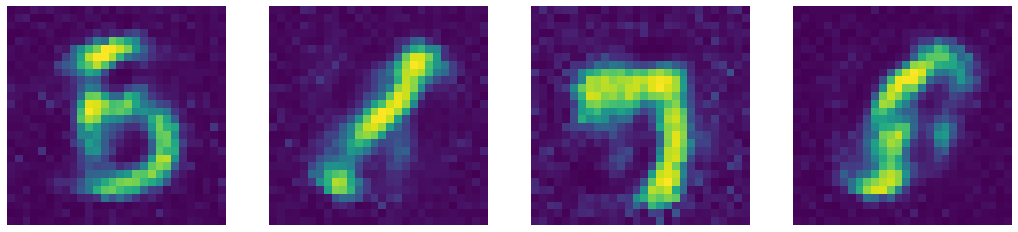

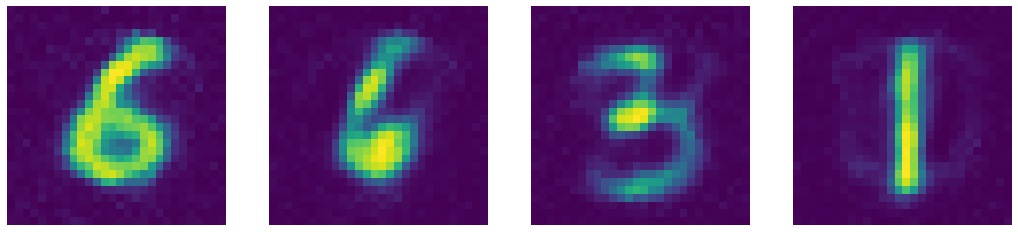

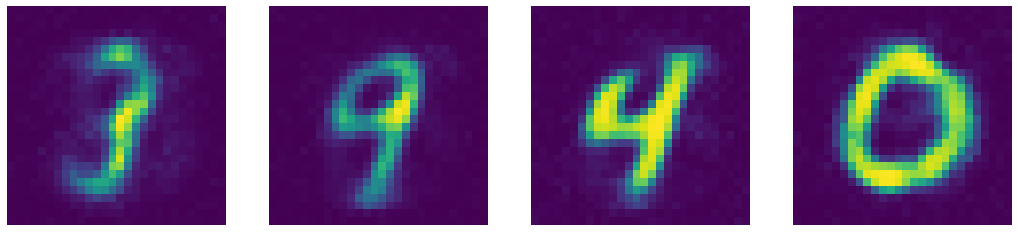

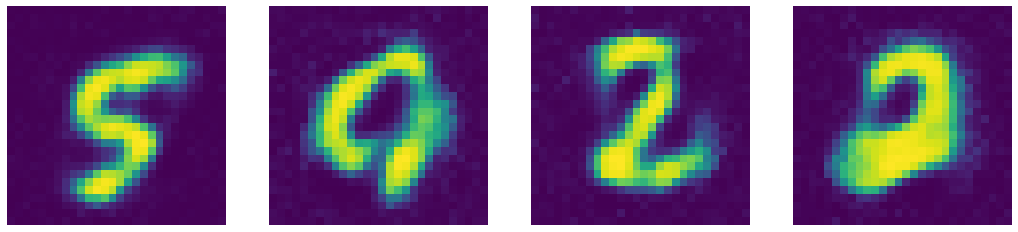

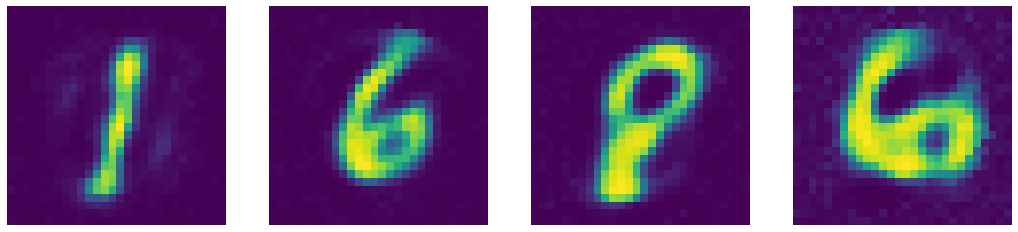

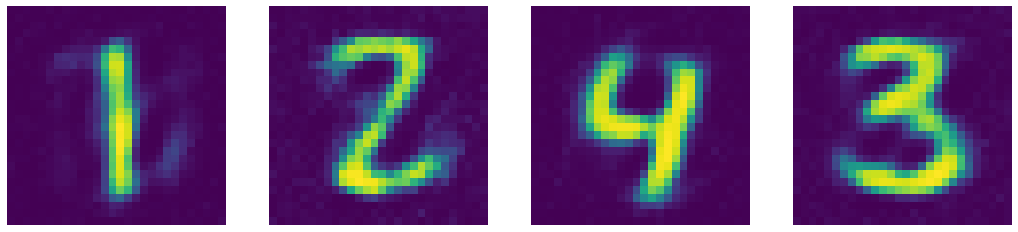

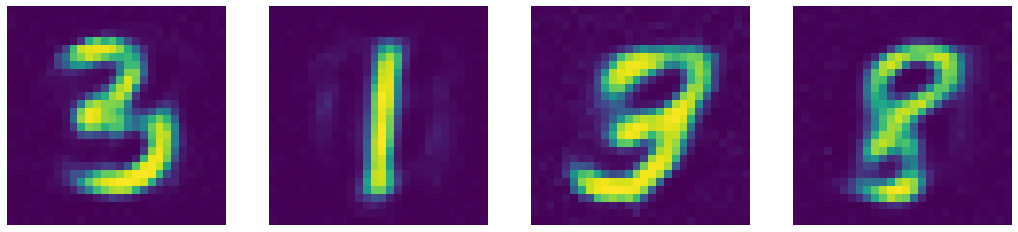

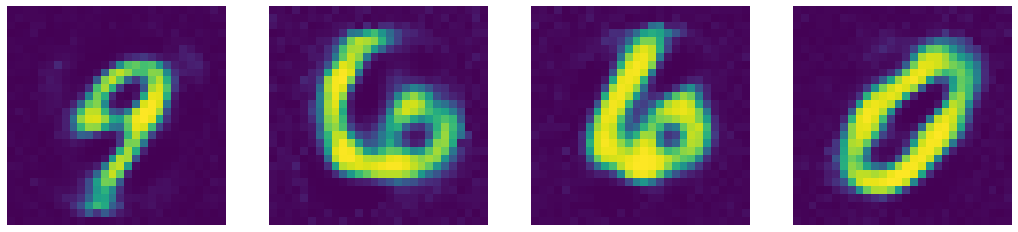

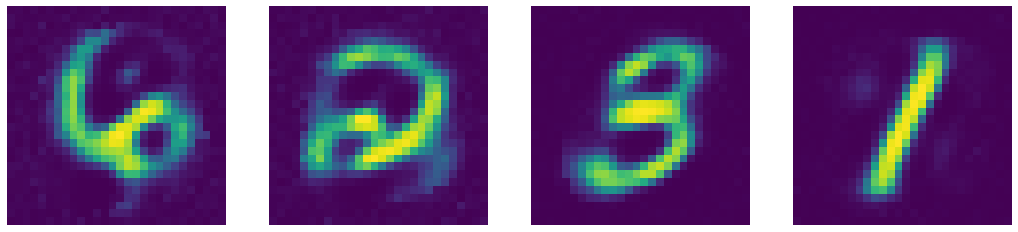

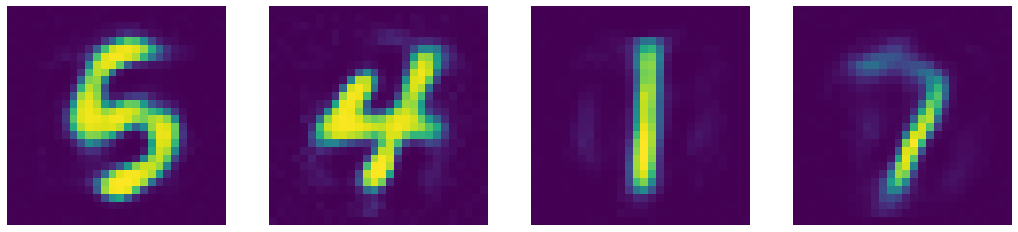

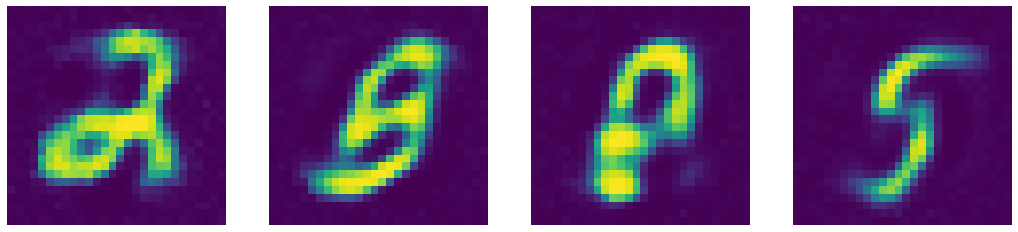

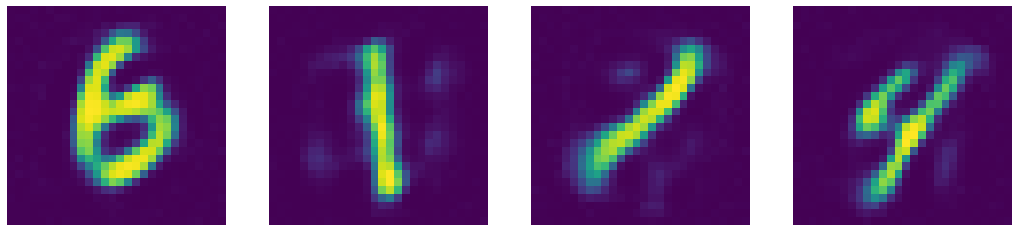

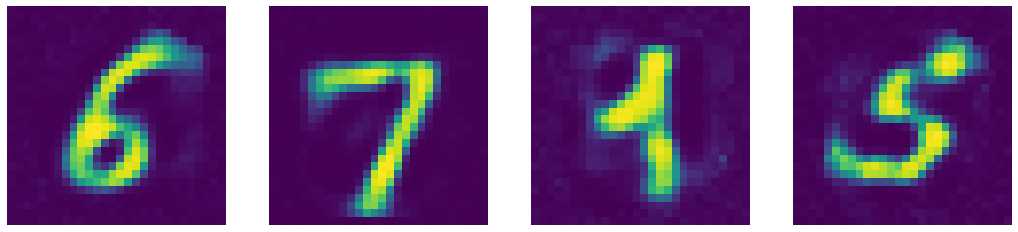

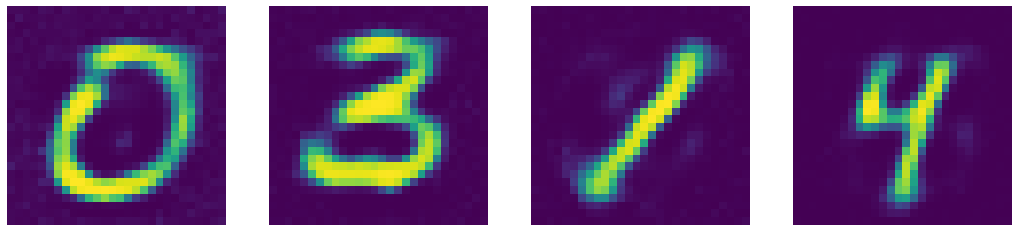

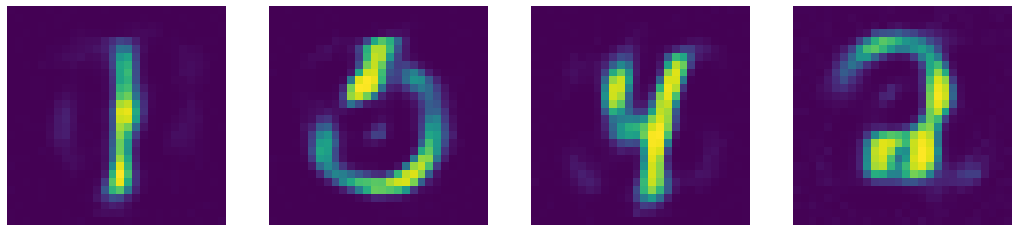

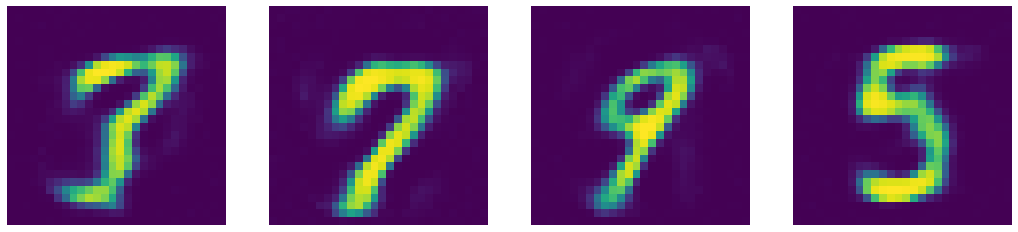

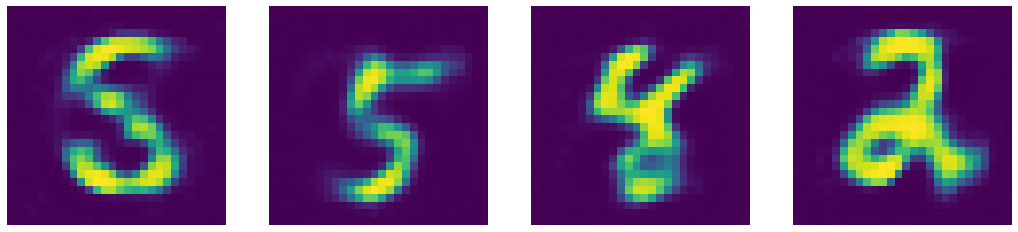

In [8]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad() # set the gradients to zero
        loss.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
        optimizer.step() # mise a jour des poids
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

9. Visualise a few kernels of the encoder :


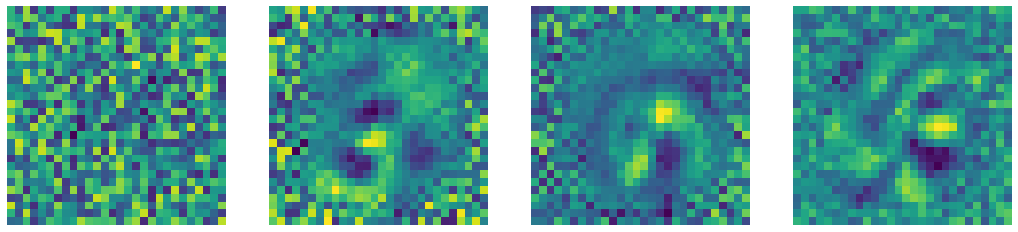

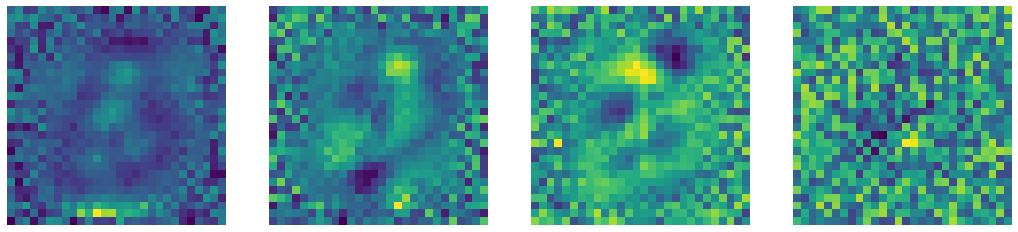

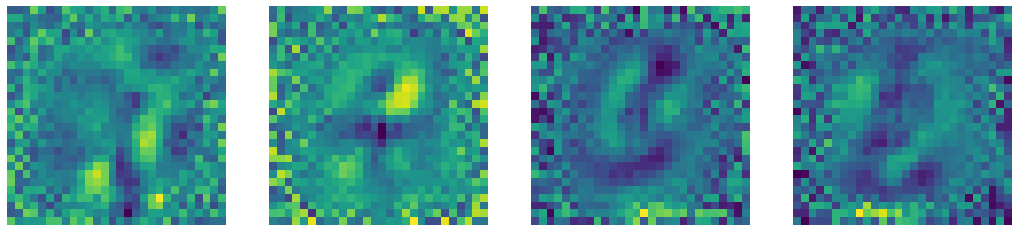

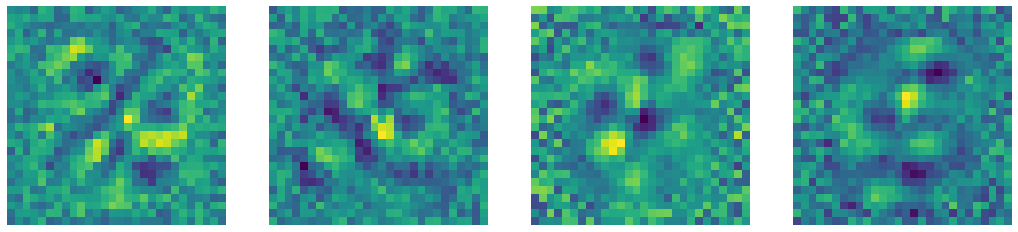

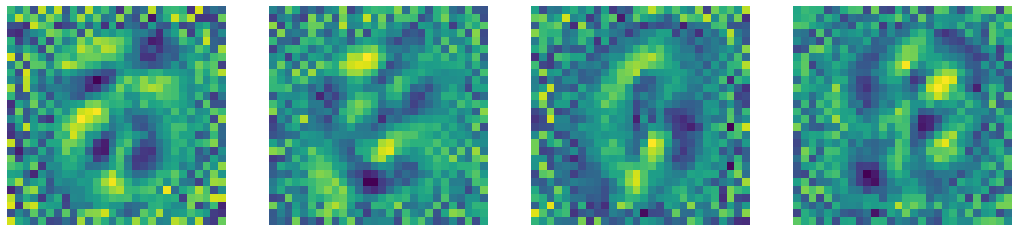

In [9]:
display_images(None, model.encoder[0].weight, 5)

## B. Use d = 500 for denoising AE (over-complete hidden layer)

In [10]:
d=500;

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()



learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epoch [1/20], loss:0.0331
epoch [2/20], loss:0.0186
epoch [3/20], loss:0.0125
epoch [4/20], loss:0.0105
epoch [5/20], loss:0.0109
epoch [6/20], loss:0.0077
epoch [7/20], loss:0.0060
epoch [8/20], loss:0.0062
epoch [9/20], loss:0.0058
epoch [10/20], loss:0.0055
epoch [11/20], loss:0.0055
epoch [12/20], loss:0.0052
epoch [13/20], loss:0.0050
epoch [14/20], loss:0.0047
epoch [15/20], loss:0.0049
epoch [16/20], loss:0.0043
epoch [17/20], loss:0.0040
epoch [18/20], loss:0.0041
epoch [19/20], loss:0.0039
epoch [20/20], loss:0.0041


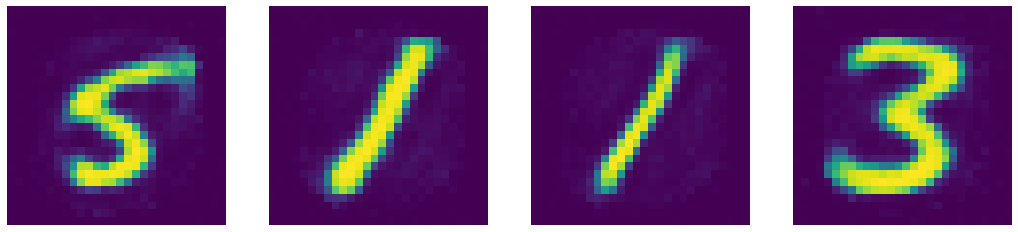

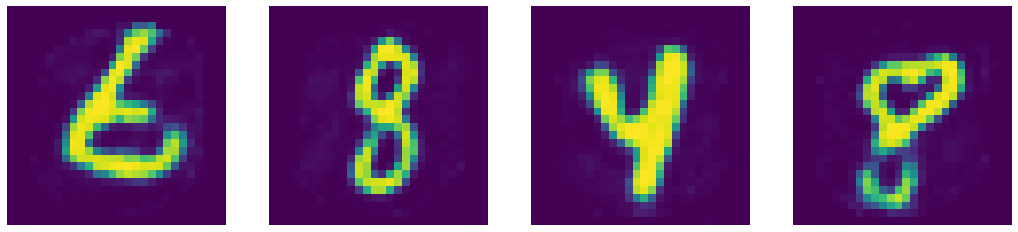

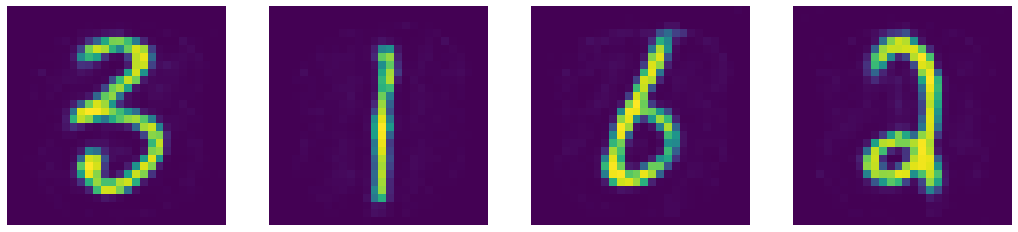

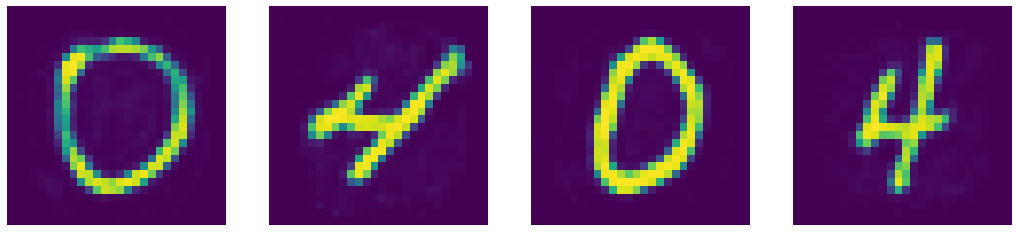

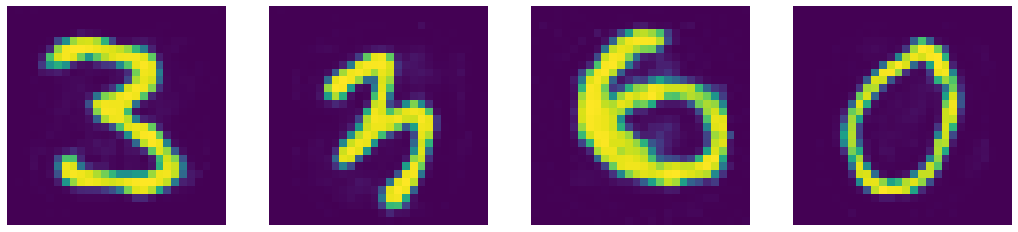

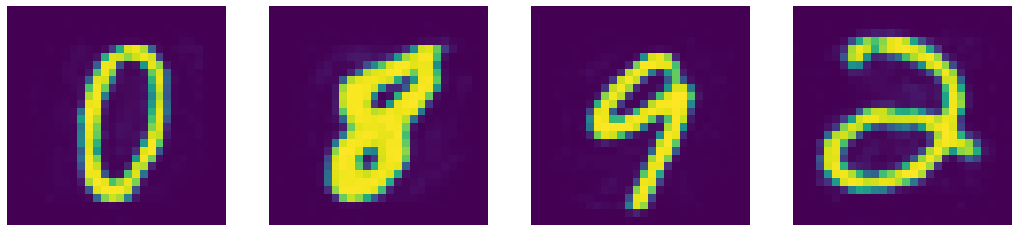

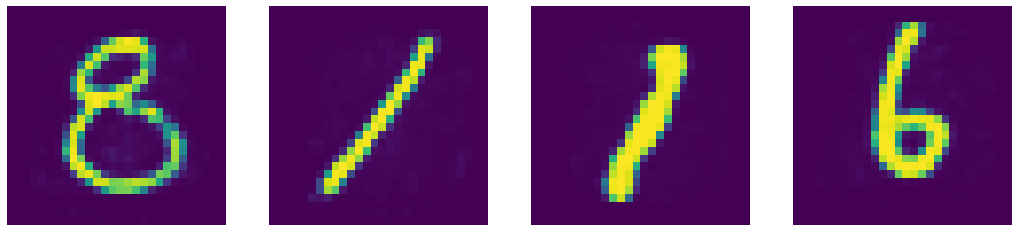

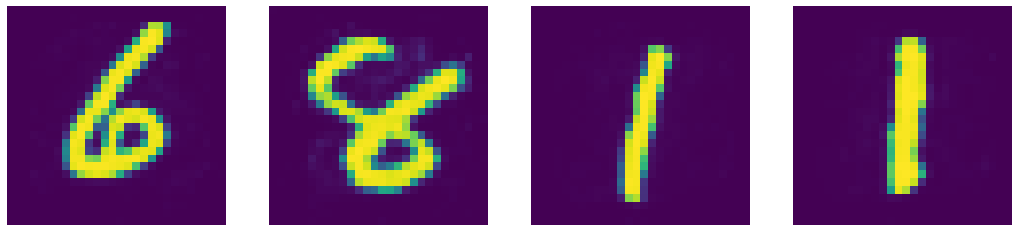

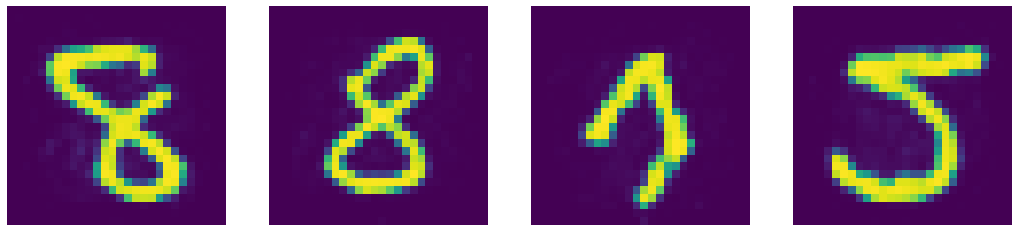

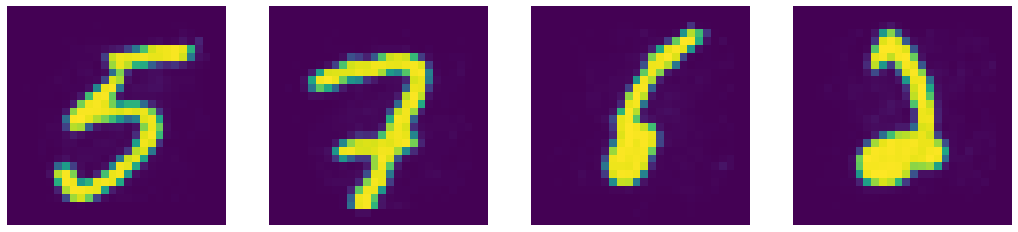

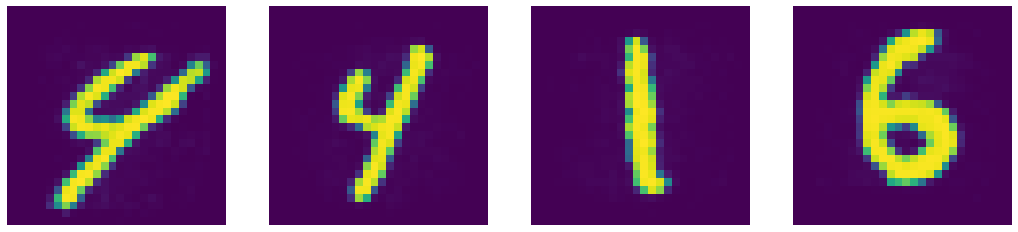

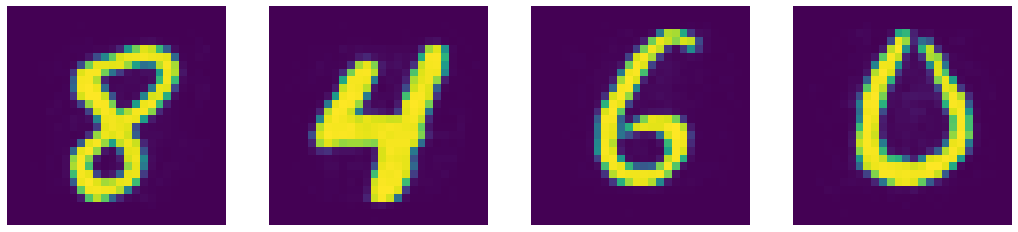

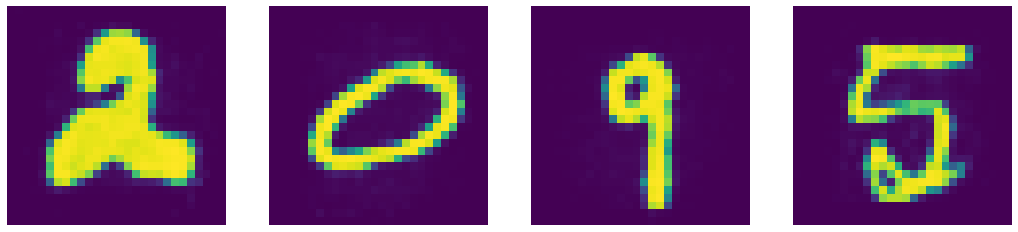

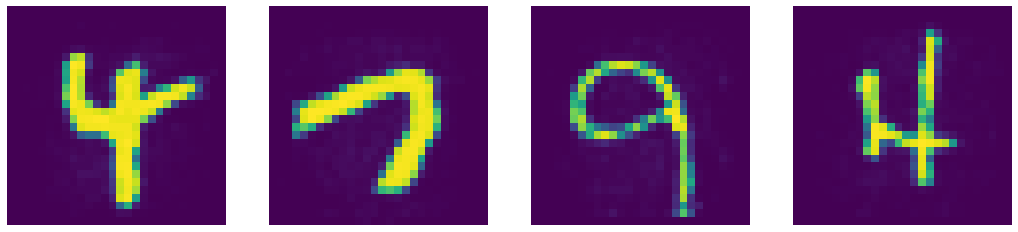

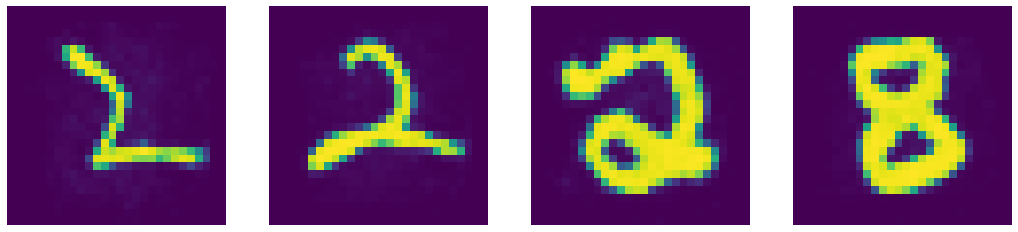

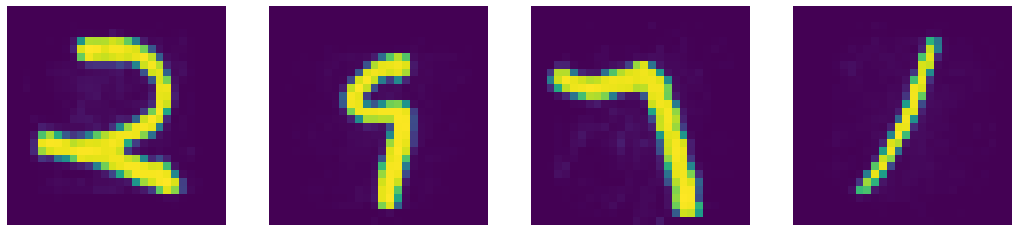

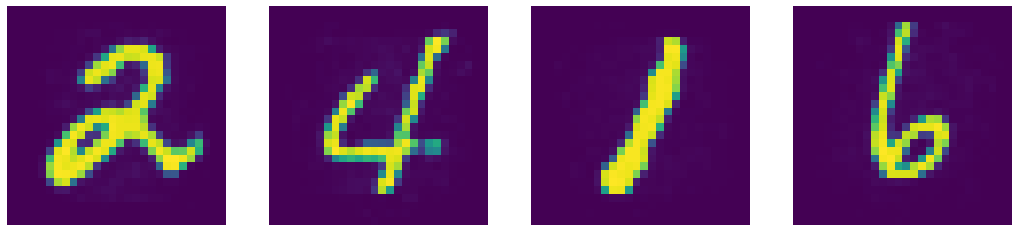

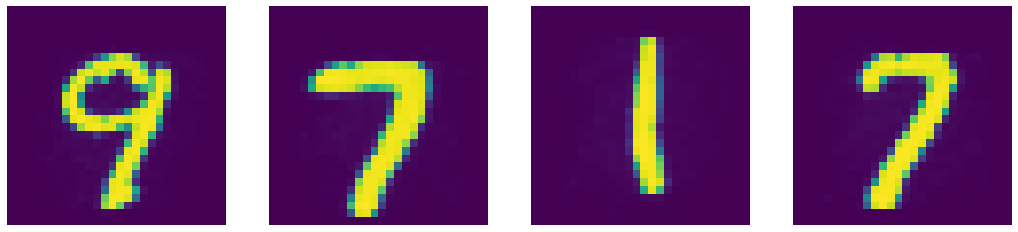

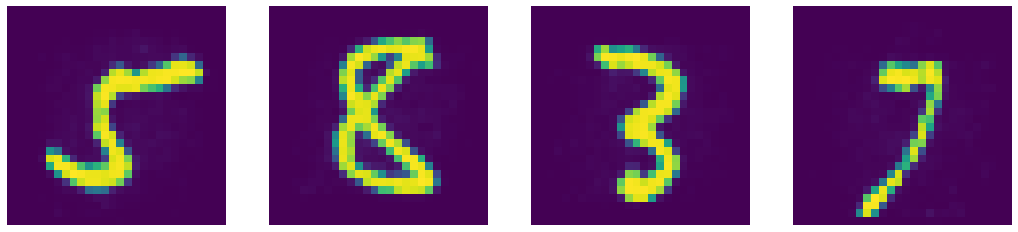

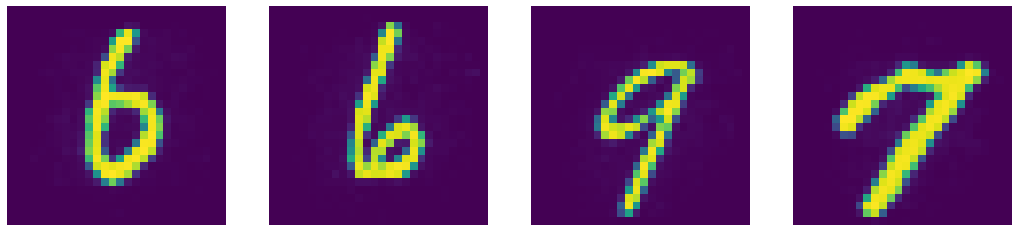

In [11]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

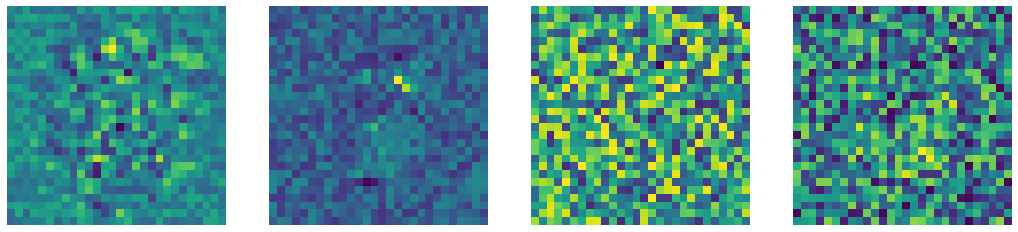

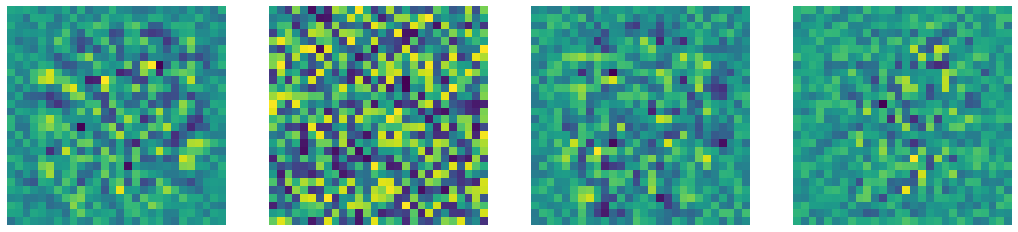

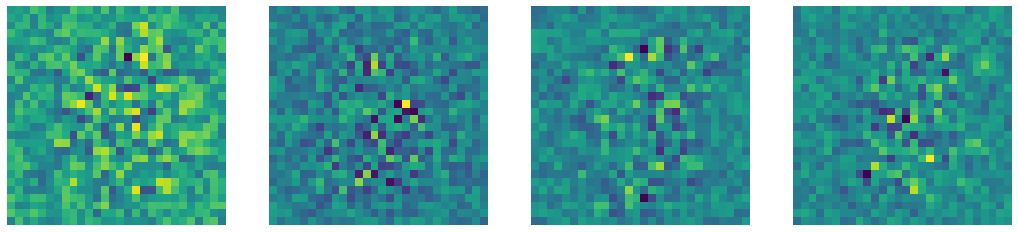

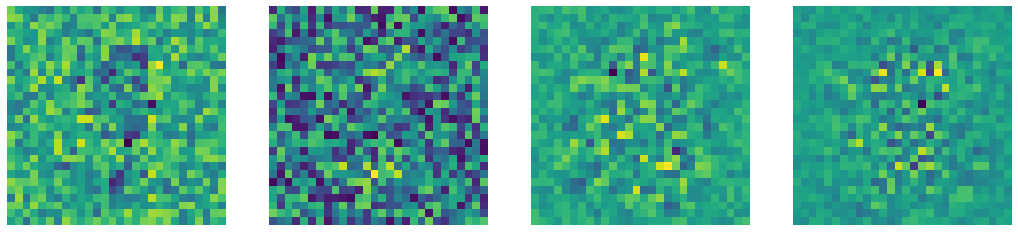

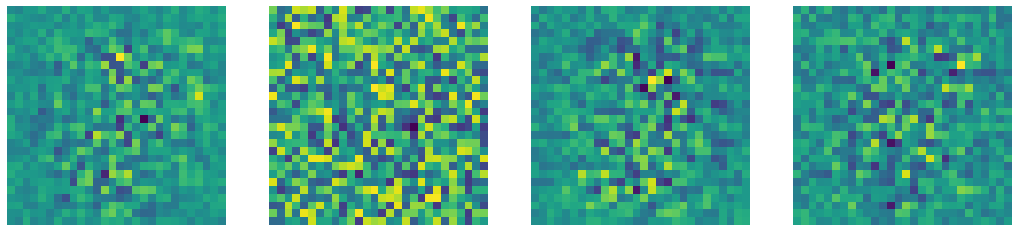

In [12]:
display_images(None, model.encoder[0].weight, 5)

C. Explain the difference between standard AE and denoising AE:

When the dimensionality of the hidden layer **d** is less than the dimensionality of the input **n** then we say it is under complete hidden layer. And similarly, when **d>n**, we call it an over-complete hidden layer.

Analyse the results and conclude.

10. Analyse the obtained results.

Pour le SAE, la perte varie entre 0.20 et 0.06. La perte ne cesse de diminuer au fil des époques jusqu'à la dernière. Ce qui en soit est une bonne nouvelle. Mais étant donné que la courbe de perte décroit jusqu'au bout et ne se stabilise pas à un moment donné, cela indique que notre modèle n'a pas fini son apprentissage. On aura donc besoin d'encore plus d'époques pour mieux entrainer ce modèle jusqu'à ce qu'il commence à se stabiliser.

Pour DAE, la perte varie entre 0.07 et 0.04. Ce qui est déjà bon. Mais à partir de l'époque 7, on constate que la diminution de la perte reste constante. Ce qui revient à dire qu'on peut arrêter son apprentissage à 7 époques pour éviter le problème de surapprentissage (over-fitting), ce qui le rendre moins performant sur de nouvelles données.

L'avantage du DAE sur SAE peut s'expliquer par la valeur de "d" car plus d est petit, plus l'image sera compressé. Le fait que l'image soit beaucoup compressé fait que l'image reconstruite devienne beaucoup plus différente de l'original.

Un autre élément qui peut influencer les résultats de l'apprentissage c'est le taux d'apprentissage. En effet, ici le taux est de 0.001. Cette valeur étant certes acceptable on va tenter de lui donne une valeur légèrement plus grande ou plus petite



11. Changes the parameters of the Autoencoder and analyse theirs impact. Conclude.


Avec un taux d'apprentissage élevé, l'apprentissage prend effectivement moins de temps, l'image de sortie se déteriore au fur et à mesure qu'on entraine le modèle. La perte est très instable et varie au cours des époques

Avec un taux d'apprentissage trop petit, on constate que la perte diminue au fil des époques mais l'apprentissage prend beaucoup plus de temps. D'où la nécessité d'ajouter plus d'époques d'apprentissage pour que la perte se stabilise. Enfin l'image reconstruite est moins bon que quand on prend un taux de 0.001

Avec une taille de sortie de 100, on obtient une image de sortie plus proche de l'image originale. Aussi, la perte part de 0.11 à 0.01. Ensuite elle se stabilise après l'époch 18.

Quand on diminue la dimension de la couche de sortie à 30, on constate qu'on obtient une image reconstruite est moins nette que celle obtenue avec une dimension de la couche de sortie égale à 500.

Conclusion
Que ce soit pour les auto-encodeurs standards ou débruiteurs, le choix de la dimension de sortie "d" est déterminant sur les résultats de sortie.

## PART2. Convolutions Neural Networks

1. Import the librariries and set the parameters

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

set_default()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2. Load the Dataset (MNIST) using PyTorch DataLoader utilities and visualize some images :


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



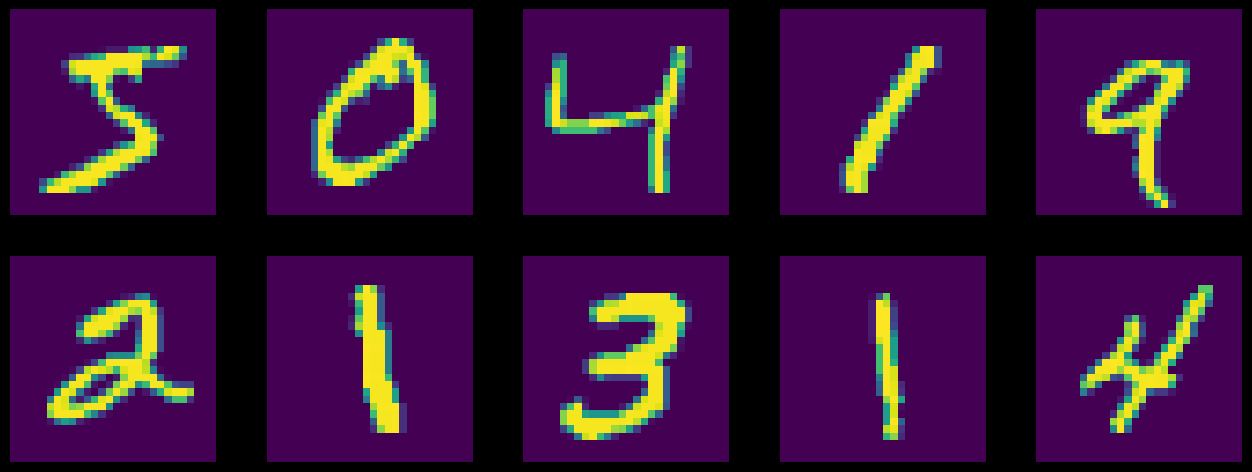

In [14]:

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');



3. Create the model classes




In [15]:
# réseau de neurone complètement connecté
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        # input_size : nbre de neurones dans la couche d'entrée
        # n_hidden   : nombre de neurones dans la couche cachée
        # ouput_size : nombre de neurones dans la couche de sortie
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)# le choix de softmax comme fonction d'activation c'est parce qu'on a plusieurs classes de sorties
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
# réseau de neurone convolutif
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) # softmax : puisque on a plusieurs classes de sorties  
        return x

4. Run on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [16]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

5. Train a small fully-connected network

In [17]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.348110
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.633167
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.023349
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.690950
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.712023
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.571253
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.520452
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.635612
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.398841
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.489342

Test set: Average loss: 0.4653, Accuracy: 8663/10000 (87%)



6. Train a ConvNet with the same number of parameters

In [18]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310427
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.956621
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.317903
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.470279
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.227467
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.396665
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.248030
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.180215
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.380753
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.109359

Test set: Average loss: 0.1485, Accuracy: 9542/10000 (95%)



7. Changes the parameters oof the model.

- Sur le modèle complètement connecté

In [19]:
accuracy_list = []

def train1(epoch, model, optimizer, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [20]:

n_hidden = 20 # number of hidden units
model_fnn__ = FC2Layer(input_size, n_hidden, output_size)
model_fnn__.to(device)
optimizer__ = optim.SGD(model_fnn__.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn__)))

for epoch in range(0, 1):
    train1(epoch, model_fnn__, optimizer__)
    test(model_fnn__)

Number of parameters: 16330
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.275925
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.226047
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.664504
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.480520
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.434491
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.251832
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.461227
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.402576
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.484477
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.504632

Test set: Average loss: 0.2955, Accuracy: 9140/10000 (91%)



- Sur le modèle convolutif

On augmente le nombre de feature maps

In [21]:

# Training settings 
n_features = 20 # number of feature maps

model_cnn_ = CNN(input_size, n_features, output_size)
model_cnn_.to(device)
optimizer_ = optim.SGD(model_cnn_.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_)))

for epoch in range(0, 1):
    train1(epoch, model_cnn_, optimizer_)
    test(model_cnn_)

Number of parameters: 27100
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.279154
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.614723
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.620714
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.193261
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.161677
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.342600
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.177166
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.150593
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.078715
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.272151

Test set: Average loss: 0.1096, Accuracy: 9689/10000 (97%)





8. Analyze the results and the impact of these paremeters.

Avant la modification des paramètres, on constate :

- Sur le modèle complètement connecté, une précision de 96% sur les données d'apprentissage et de 88% sur les données de test. Avec une perte de 0.472770 sur les données d'apprentissage et de 0.4140 sur les données de test. Ce qui indique que le modèle s'est trop entrainé sur les données d'apprentissage et fait des prédictions moins bonnes sur les données de test. Il y a un sur-apprentissage.

- Sur le modèle convolutif, On obtient une précision de 96% sur les données d'apprentissage et 95% sur les données de test. Ce qui est bien. Par contre sur la perte, on pense pouvoir faire mieux en ajoutant soit une autre couche de convolution ou en augmentant la taille des feature_maps

Après changement des paramètres, on constate :

- L'augmentation du nombre de couches cachées dans le réseau de neurone complètement connecté permet d'avoir des meilleurs résultats. En effet, avec 20 couches cachées, on passe de 88% d'accuracy à 91%. Ce qui permet d'obtenir des meilleurs résultats.

- L'augmentation du nombre des feature maps à 20 dans le réseau de neurone convolutif améliore également l'accuracy sur les données de test.